In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from scipy.constants import pi, c
from scipy.signal import hilbert, find_peaks
from scipy.interpolate import interp1d

In [2]:
plt.rcParams['figure.figsize'] = [10,5]

In [3]:
#Define conversion functions/factors to get to/from meep units and kms
#Length factor to transform lengths in kms
l_unit = 1e-6 #1 um
t_unit = l_unit/c #time unit is length/c

#multiplicative constants to convert frequencies from meep to kms hertz
freq_unit = c/l_unit

print("1 meep Length unit is", l_unit*1e+6, "um")
print("1 meep Time unit is", t_unit*1e+15, "fs")
print("1 meep Frequency unit is", freq_unit*1e-12, "THz")

1 meep Length unit is 1.0 um
1 meep Time unit is 3.3356409519815204 fs
1 meep Frequency unit is 299.792458 THz


# Resolution

In [4]:
#courant factor
S = 0.5

#resolution is number of pixels per meep unit
resolution = 20

#resolutions in meep units
space_res = 1/resolution
time_res = space_res*S

print("Pixel per unit: ", resolution)

print("Space resolution [meep]: ", space_res)
print("Time resolution [meep]: ", time_res)

print("Space resolution [um]: ", space_res*l_unit*1e+6)
print("Time resolution [fs]: ", time_res*t_unit*1e+15)

Pixel per unit:  20
Space resolution [meep]:  0.05
Time resolution [meep]:  0.025
Space resolution [um]:  0.049999999999999996
Time resolution [fs]:  0.08339102379953803


# Geometry Definition
Cell

In [5]:
#define cell size and resolution
#Cell size is in meep units
#center is in (0,0), ranges in x=(-sx/2,sx/2), y=(-sy/2,sy/2)
sx = 20
sy = 10

cell = mp.Vector3(sx, sy)

#boundary conditions thickness
pml_thickness = 1.0

#automatic positioning of boundaries
x_bound_up = sx/2 - pml_thickness
x_bound_low = -sx/2 + pml_thickness

y_bound_up = sy/2 - pml_thickness
y_bound_low = -sy/2 + pml_thickness

Bragg Reflector


In [6]:
#materials refractive indexes
n_1 = 3.5 #Si
n_2 = 1.45 #SiO2

#Bragg params
#central cavity (if present)
width_cavity = 1

#Layer thickness
width_1 = 0.5
width_2 = 0.5

#Half the number of layers
N_layers = 6

#The x position of the BR boundaries
bragg_width = (width_2 + width_1)*N_layers


Source

In [7]:
#Soure parameters
source_x = -bragg_width/2 - 4
source_y = 0

source_width = 7

#note: df is not really the frequency sigma
f_central = 0.15
df = 0.1


print("#Source pulse frequency: fcent= ", f_central*freq_unit*1e-12, " THz, df= ",df*freq_unit*1e-12, " THz" )
print("#Source vacuum wavelength: lambda = ",  c/(f_central*freq_unit)*1e+6, "um, dlambda = ",c/(df*freq_unit)*1e+6,"um")
print("#Source material 1 wavelength: lambda = ",  (c/n_1)/(f_central*freq_unit)*1e+6, "um, dlambda = ", (c/n_1)/(df*freq_unit)*1e+6,"um")
print("#Source material 2 wavelength: lambda = ",  (c/n_2)/(f_central*freq_unit)*1e+6, "um, dlambda = ", (c/n_2)/(df*freq_unit)*1e+6,"um")

#Source pulse frequency: fcent=  44.9688687  THz, df=  29.9792458  THz
#Source vacuum wavelength: lambda =  6.666666666666667 um, dlambda =  10.0 um
#Source material 1 wavelength: lambda =  1.9047619047619047 um, dlambda =  2.857142857142857 um
#Source material 2 wavelength: lambda =  4.597701149425287 um, dlambda =  6.8965517241379315 um


Monitors

In [8]:

#Monitor parameters
#input
mon_1_x = -bragg_width/2 - 2
mon_1_width = sy - 2*pml_thickness

#output
mon_2_x = bragg_width/2 + 2
mon_2_h = sy - 2*pml_thickness

#number of sampling points in frequency for fourier transform of fields accumulated
N_freq = 300

#central frequency
f_mon_central = f_central
#width of sampled frequency band
df_mon = df



#Point for simulation termination condition
check_pt = mp.Vector3(0, bragg_width/2 + 0.5)


# Normalization Run
No DBR

-----------
Initializing structure...
time for choose_chunkdivision = 0.000190973 s
Working in 2D dimensions.
Computational cell is 20 x 10 x 0 with resolution 20
time for set_epsilon = 0.094696 s
-----------
field decay(t = 50.025000000000006): 0.06543635169079837 / 0.06543635169079837 = 1.0
field decay(t = 100.05000000000001): 3.2147996976159596e-11 / 0.06543635169079837 = 4.912865119385962e-10
Normalizing field data...
run 0 finished at t = 100.05000000000001 (4002 timesteps)
Generating MP4...


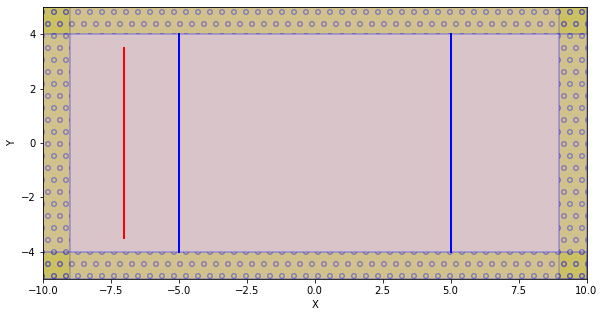

In [9]:

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*8),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    resolution=resolution)

# Flux Monitor 1
incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, 0), size=mp.Vector3(0, mon_1_width, 0))
incident = sim.add_flux(f_mon_central, df_mon, N_freq, incident_fr)

# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, 0), size=mp.Vector3(0,mon_2_h,0))
tran = sim.add_flux(f_mon_central, df_mon, N_freq, tran_fr)

animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})

#Simulate
mp.verbosity(1)
sim.run(mp.at_every(1, animate), until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, check_pt, 1e-3))

animate.to_mp4(10, "Ez_norm.mp4")

In [10]:
Video("Ez_norm.mp4")

In [11]:

#Get Fourier-transformed fields of incident pulse
norm_incident_data = sim.get_flux_data(incident)

#Get fluxes from fourier transformed fields transmitted
norm_tran_flux = mp.get_fluxes(tran)

#Get fluxes from fourier transformed incident fields
norm_inc_flux = mp.get_fluxes(incident)

flux_freqs = mp.get_flux_freqs(tran)

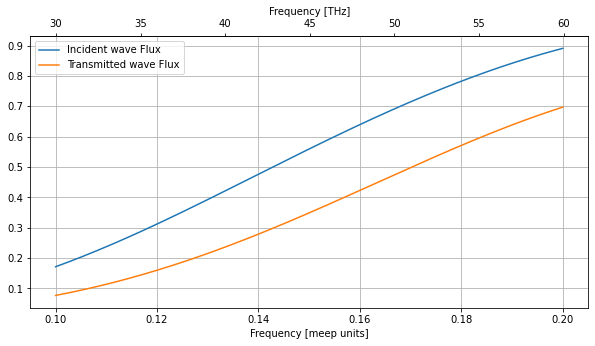

In [12]:
plt.plot(flux_freqs, norm_inc_flux, label="Incident wave Flux")
plt.plot(flux_freqs, norm_tran_flux, label="Transmitted wave Flux")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')

plt.legend()
plt.grid()

In [13]:
sim.reset_meep()

# Actual Run

In [14]:
#define geometry

#Background material
geometry = [mp.Block(mp.Vector3(bragg_width, mp.inf, mp.inf),
                     center=mp.Vector3(0,0),
                     material=mp.Medium(index=n_1))]

#Layers Material
for ii in range(N_layers):
    geometry.append(mp.Block(mp.Vector3(width_2, mp.inf, mp.inf),
                     center=mp.Vector3(ii*(width_1+width_2) -bragg_width/2 + width_1 + width_2/2, 0),
                     material=mp.Medium(index=n_2)))
    
#define sources
sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*8),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, 0),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]


#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)


In [15]:
##Flux Monitors Definition

#First instantiate a flux region object by telling its geometric parameters
#Then call add_flux on simulation object, passing the fluxregion as parameter. Returns flux object

#This tells meep to perform the following:
#For each of the chosen frequencies, and for each of the fields components,
#accumulate the discrete fourier transform until the end of the simulation

#Desired frequencies are in (fcen-df/2, fcen+df/2)

# Flux Monitor 1
refl_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, 0), size=mp.Vector3(0,mon_1_width,0))
refl = sim.add_flux(f_mon_central, df_mon, N_freq, refl_fr)

# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, 0), size=mp.Vector3(0,mon_2_h,0))
tran = sim.add_flux(f_mon_central, df_mon, N_freq, tran_fr)

In [16]:
#load normalization data
sim.load_minus_flux_data(refl, norm_incident_data)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 2D dimensions.
Computational cell is 20 x 10 x 0 with resolution 20
     block, center = (0,0,0)
          size (6,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
     block, center = (-2.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-0.25,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0.75,0,0)
          size (0.5,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric con

field decay(t = 50.025000000000006): 0.009046496891182462 / 0.009046496891182462 = 1.0
field decay(t = 100.05000000000001): 0.000368393476887562 / 0.009046496891182462 = 0.04072222444984552
on time step 5893 (time=147.325), 0.000678791 s/step
field decay(t = 150.07500000000002): 8.066286941606987e-05 / 0.009046496891182462 = 0.008916475668575228
field decay(t = 200.10000000000002): 1.4170226145846822e-05 / 0.009046496891182462 = 0.001566377164143881
field decay(t = 250.125): 2.5398432422603396e-06 / 0.009046496891182462 = 0.0002807543375973413
Normalizing field data...
run 0 finished at t = 250.125 (10005 timesteps)
Generating MP4...


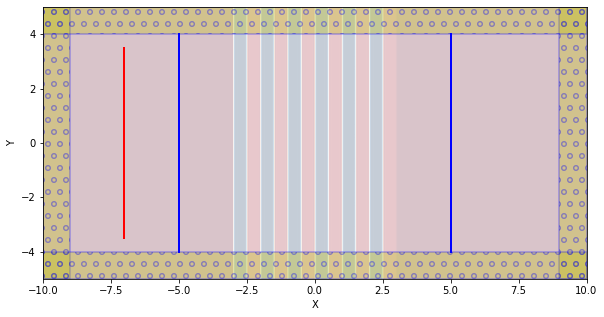

In [17]:
#Runs simulation and save animation of Ez
animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})


sim.run(mp.at_every(1, animate), until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, check_pt, 1e-3))
        #until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3))

animate.to_mp4(10, "Ez_DBR.mp4")

In [18]:
Video("Ez_DBR.mp4")

In [19]:
# Get Final Fluxes
bragg_tran_flux = np.array(mp.get_fluxes(tran))
bragg_refl_flux = np.array(mp.get_fluxes(refl))*(-1)

flux_freqs = np.array(mp.get_flux_freqs(refl))

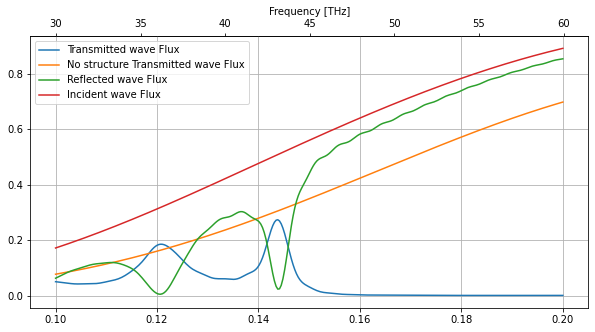

In [20]:
plt.plot(flux_freqs, bragg_tran_flux, label="Transmitted wave Flux")
plt.plot(flux_freqs, norm_tran_flux, label="No structure Transmitted wave Flux")

plt.plot(flux_freqs, bragg_refl_flux, label="Reflected wave Flux")

plt.plot(flux_freqs, norm_inc_flux, label="Incident wave Flux")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')

plt.legend()
plt.grid()

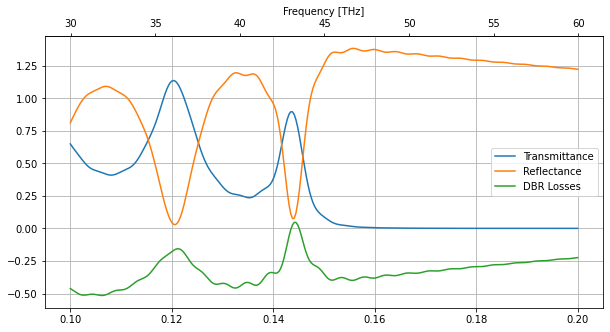

In [21]:
# Transmittance and reflectance

wvlength = 1/flux_freqs

T = bragg_tran_flux/norm_tran_flux
R = bragg_refl_flux/norm_tran_flux
Losses = 1-T-R

plt.plot(flux_freqs, T, label="Transmittance")
plt.plot(flux_freqs, R, label="Reflectance")
plt.plot(flux_freqs, Losses, label="DBR Losses")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')

plt.legend()
plt.grid()